# note
__[This](https://github.com/BVLC/caffe/blob/master/examples/02-fine-tuning.ipynb) is the original notebook where the following code was adopted from__

# some set up

### import the required libraries

In [1]:
caffe_root = '/opt/caffe/'
data_root = '/home/kaggle/data/'

In [2]:
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

caffe.set_device(0)
caffe.set_mode_gpu()

import numpy as np
from pylab import *
%matplotlib inline
import tempfile

### load pretrained weights, labels, and mean image

In [3]:
# This downloads the ilsvrc auxiliary data (mean file, etc),
import os
os.chdir(caffe_root)  # run scripts from caffe root
!data/ilsvrc12/get_ilsvrc_aux.sh
!scripts/download_model_binary.py models/bvlc_reference_caffenet

Downloading...
--2016-07-23 09:15:10--  http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858008 (17M) [application/octet-stream]
Saving to: 'caffe_ilsvrc12.tar.gz'

100%[======================================>] 17,858,008  1.58MB/s   in 12s    

2016-07-23 09:15:23 (1.42 MB/s) - 'caffe_ilsvrc12.tar.gz' saved [17858008/17858008]

Unzipping...
Done.
Model already exists.


In [4]:
# Define weights, the path to the ImageNet pretrained weights we just downloaded, and make sure it exists.
import os
weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
assert os.path.exists(weights)

### load StateFarm data

In [5]:
# download StateFarm data
# Make sure you have read the README file under data directory
import os
os.chdir(data_root)
if os.path.isdir('train'):
    print "dataset is already exists"
else:
    !bash get_datasets.sh

dataset is already exists


In [6]:
# define train and valid sets
import pandas as pd

labels = pd.read_csv(data_root+'driver_imgs_list.csv').drop('subject', 1)[['img', 'classname']]
labels['img'] = labels.apply(lambda row: data_root+'train/'+row.classname+'/'+row.img, 1)
labels['classname'] = labels['classname'].map(lambda l: l[1])
labels = labels.reindex(np.random.permutation(labels.index))

labels.iloc[0:2000].to_csv(data_root+'valid.txt', sep=' ', header=False, index=False)
labels.iloc[2000:].to_csv(data_root+'train.txt', sep=' ', header=False, index=False)
labels = None

NUM_STATEFARM_LABELS = 10
kaggle_labels = [
    'c0: safe driving',
    'c1: texting - right',
    'c2: talking on the phone - right',
    'c3: texting - left',
    'c4: talking on the phone - left',
    'c5: operating the radio',
    'c6: drinking',
    'c7: reaching behind',
    'c8: hair and makeup',
    'c9: talking to passenger'
]

# some definitions

### defining caffe net
caffenet, a function which initializes the CaffeNet architecture (a minor variant on AlexNet), taking arguments specifying the data and number of output classes.

In [7]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data=None, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        return f.name

### define solver
function solver to create our Caffe solvers, which are used to train the network (learn its weights)

In [8]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.001, stepsize=150, gamma=0.1):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = gamma
    s.stepsize = stepsize

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = data_root + 'models'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

### define kaggle_net
function kaggle_net which calls caffenet on data from the StateFarm dataset.

The new network will also have the CaffeNet architecture, with differences in the input and output:

* the input is the Kaggle StateFarm data we downloaded, provided by an ImageData layer
* the output is a distribution over 10 classes rather than the original 1000 ImageNet classes
* the classification layer is renamed from fc8 to fc8_kaggle to tell Caffe not to load the original classifier (fc8) weights from the ImageNet-pretrained model

In [9]:
def kaggle_net(train=True, learn_all=True, batch_size=128):
    source = data_root + 'train.txt' if train else 'valid.txt'

    transform_param = dict(mirror=train, crop_size=227,
        mean_file=caffe_root + 'data/ilsvrc12/imagenet_mean.binaryproto')

    kaggle_data, kaggle_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=batch_size, new_height=256, new_width=256, ntop=2)
    
    return caffenet(data=kaggle_data, label=kaggle_label, train=train,
                    num_classes=NUM_STATEFARM_LABELS,
                    classifier_name='fc8_kaggle',
                    learn_all=learn_all)

### define run_solver
run_solvers, a function that takes a list of solvers and steps each one in a round robin manner, recording the accuracy and loss values each iteration. At the end, the learned weights are saved to a file.

In [10]:
def run_solvers(niter, solvers, disp_interval=100):
    """
    Run solvers for niter iterations,
    returning the loss and accuracy recorded each iteration.
    'solvers' is a list of (name, solver) tuples.
    """
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

# train the model

kaggle solver: train net initialized to the ImageNet-pretrained weights (this is done by the call to the copy_from method)

In [11]:
import time
start_time = time.time()
niter = 600  # number of iterations to train
# base_lr: starting learning rate = 0.001
# learn_all: update the weights in all layers = True
# stepsize: learning rate stepsize = 100

# Reset kaggle_solver as before.
kaggle_solver_filename = solver(kaggle_net())
kaggle_solver = caffe.get_solver(kaggle_solver_filename)
kaggle_solver.net.copy_from(weights)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', kaggle_solver)]
loss, acc, weights = run_solvers(niter, solvers)
print 'Done.'

train_loss = loss['pretrained']
train_acc = acc['pretrained']
kaggle_weights = weights['pretrained']

# Delete solvers to save memory.
del kaggle_solver, solvers

print "Finished training the model in %f s" % (time.time() - start_time)

Running solvers for 600 iterations...
  0) pretrained: loss=2.303, acc=11%
100) pretrained: loss=0.325, acc=85%
200) pretrained: loss=0.199, acc=94%
300) pretrained: loss=0.212, acc=91%
400) pretrained: loss=0.159, acc=95%
500) pretrained: loss=0.293, acc=91%
599) pretrained: loss=0.138, acc=97%
Done.
Finished training the model in 630.632486 s


### visualize the learning process

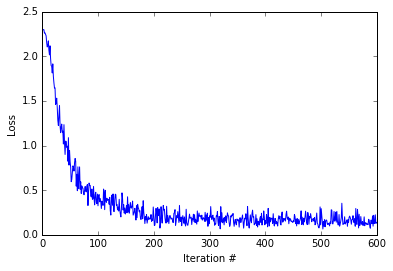

In [12]:
plot(np.vstack([train_loss]).T)
xlabel('Iteration #')
ylabel('Loss')

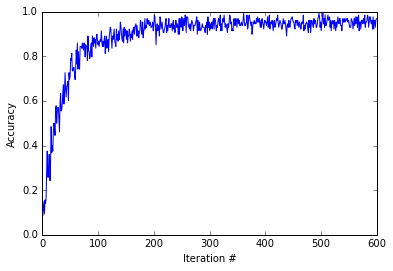

In [13]:
plot(np.vstack([train_acc]).T)
xlabel('Iteration #')
ylabel('Accuracy')

In [14]:
def eval_kaggle_net(weights, test_iters=40):
    test_net = caffe.Net(kaggle_net(train=False), weights, caffe.TEST)
    accuracy = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    return test_net, accuracy

In [15]:
test_net, accuracy = eval_kaggle_net(kaggle_weights)
print 'Validation accuracy, trained from ImageNet initialization: %3.1f%%' % (100*accuracy, )
del test_net

Validation accuracy, trained from ImageNet initialization: 97.8%


# Extract Probabilities

### define helper functions

In [16]:
def initialize_transformer(net):
    mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
    mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values

    # create transformer for the input called 'data'
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

    transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
    transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
    transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
    transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR
    
    return transformer

def preprocess_batch(images, transformer):
    transformed_images = map(
        lambda image: transformer.preprocess('data', caffe.io.load_image(image)),
        images
    )
    return transformed_images

def process_batch(net, images):
    net.blobs['data'].data[...] = images
    probs = net.forward(start='conv1')['probs']
    return probs

def process_image(net, image):
    net.blobs['data'].data[0, ...] = image
    p = net.forward(start='conv1')['probs'][0]
    return p

def write_to_file(f_name, probs, images_name):
    with open(data_root + f_name, "a") as f:
        for i in xrange(len(probs)):
            f.write(images_name[i][23:])
            for p in probs[i]:
                f.write(",%f" % p)
            f.write('\n')

### extract probabilities for each class

In [17]:
def extract_probabilities(net, image_set, batch_size=128, out_file='submission.txt', display_interval=10):
    start_time = time.time()
    with open(data_root + out_file, "a") as f:
        f.write("img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9\n")
    
    transformer = initialize_transformer(net)
    in_batch_size = (len(image_set)/batch_size)*batch_size    
    
    for s in range(0, in_batch_size, batch_size):
        images = image_set[s:s+batch_size]
        preprocessed_images = preprocess_batch(images, transformer)
        probs = process_batch(net, preprocessed_images)
        write_to_file(out_file, probs, images)
        if (s / batch_size) % display_interval == 0:
            print "Processed %i images in %f sec" % (s, time.time() - start_time)
        
    # for some reason reshaping the image data layer causes the kernel to crash    
    left = image_set[in_batch_size:]
    probs = []
    for image in left:
        preprocessed_image = transformer.preprocess('data', caffe.io.load_image(image))
        probs.append(process_image(net, preprocessed_image))
    write_to_file(out_file, probs, left)
    
    print "Finished extracting probabilities in %f sec" % (time.time() - start_time)

In [18]:
test_images = map(lambda name: data_root+'test/'+name, os.listdir(data_root+'test'))
test_net = caffe.Net(kaggle_net(train=False), kaggle_weights, caffe.TEST)

In [19]:
extract_probabilities(test_net, test_images)

Processed 0 images in 2.900404 sec
Processed 1280 images in 31.159336 sec
Processed 2560 images in 60.912330 sec
Processed 3840 images in 90.451976 sec
Processed 5120 images in 119.914245 sec
Processed 6400 images in 149.083819 sec
Processed 7680 images in 178.196667 sec
Processed 8960 images in 207.226098 sec
Processed 10240 images in 236.546783 sec
Processed 11520 images in 265.918538 sec
Processed 12800 images in 295.102234 sec
Processed 14080 images in 324.207299 sec
Processed 15360 images in 353.337148 sec
Processed 16640 images in 383.233363 sec
Processed 17920 images in 412.236261 sec
Processed 19200 images in 441.205734 sec
Processed 20480 images in 470.138082 sec
Processed 21760 images in 499.137592 sec
Processed 23040 images in 528.699056 sec
Processed 24320 images in 558.050678 sec
Processed 25600 images in 587.362133 sec
Processed 26880 images in 616.728791 sec
Processed 28160 images in 645.600376 sec
Processed 29440 images in 674.482255 sec
Processed 30720 images in 703.34